In [25]:
print('welcome...')

welcome...


In [ ]:
%pip install textstat
%pip install rouge_score
%pip install bert_score
%pip install gensim

In [41]:
import numpy as np 
import pandas as pd 
import re
from keras import backend as K 
# import gensim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as K 
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import pickle
from textstat import flesch_reading_ease, flesch_kincaid_grade
from datasets import load_dataset, Dataset
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
from bert_score import score
import seaborn as sns

In [8]:
contraction_mapping = {
    "ain't": "is not",
    "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you",
    "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
    "I've": "I have", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have",
    "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
    "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
    "so've": "so have", "so's": "so as",
    "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have",
    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
    "we'll've": "we will have", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
    "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
    "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
    "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"
}

In [9]:
class DataPreprocessor:
    def __init__(self):
        pass
    
    def load_csv_from_google_drive(self, url, name):
        # Attempting to load a CSV file from a Google Drive link into a Pandas DataFrame.
        try:
            # Extracting file ID from the original URL to construct a direct download link.
            url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

            # Loading the CSV data from the constructed URL into a Pandas DataFrame.
            df = pd.read_csv(url,encoding='iso-8859-1')

            # Confirmation message upon successful loading of CSV data.
            print(f'{name} CSV loaded successfully.')

            # Returning the loaded DataFrame.
            return df

        except Exception as e:
            # Handling any exceptions that may occur during the process and printing the error message.
            print('Exception occurred: ', e)

    def load_data(self,):
        print('Loading the summary dataset...')
        summary_df  = self.load_csv_from_google_drive("https://drive.google.com/file/d/1jjjtai8R0BTfTtfucbOQPCJTllXfV9Dy/view?usp=sharing", "Summary")
        
        print('\nLoading the raw dataset...')
        raw_df  = self.load_csv_from_google_drive("https://drive.google.com/file/d/1pt4kBnL0i-qtBKwgxBeTTKnkGINq8miE/view?usp=sharing", "Raw")

        # preprocessing steps
        raw_df_copy =  raw_df.iloc[:,0:2].copy()
        summary_df_copy = summary_df.iloc[:,0:6].copy()
        summary_df_copy['text'] = summary_df_copy['author'].str.cat(summary_df_copy['date'].str.cat(summary_df_copy['read_more'].str.cat(summary_df_copy['text'].str.cat(summary_df_copy['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")

        data = pd.DataFrame()
        data['text'] = pd.concat([raw_df_copy['text'], summary_df_copy['text']], ignore_index=True)
        data['summary'] = pd.concat([raw_df_copy['headlines'], summary_df_copy['headlines']], ignore_index=True)

        return data
 
    
    def replace_contractions(self, text):
        def replace(match):
            return contraction_mapping[match.group(0)]
        return re.sub("|".join(contraction_mapping.keys()), replace, text)

    
    def clean_text(self, _column):
        for _text in _column:
             # Convert to string and lowercase once
            _text = str(_text).lower() 

            # Remove escape characters
            _text = re.sub(r"[\t\r\n]", ' ', _text)

            # Remove multiple consecutive special characters
            _text = re.sub(r"(__+|--+|~~+|\+\+|\.\.+)", ' ', _text)

            # Remove specific special characters
            _text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', _text)

            # Remove specific patterns
            _text = re.sub(r"(mailto:|\\x9\d)", ' ', _text)
            _text = re.sub(r"([iI][nN][cC]\d+)", 'inc_num', _text)
            _text = re.sub(r"([cC][mM]\d+)|([cC][hH][gG]\d+)", 'cm_num', _text)

            # Remove punctuation at the end of words
            _text = re.sub(r"(\.\s+|\-\s+|\:\s+)", ' ', _text)

            # Remove single characters between spaces
            _text = re.sub(r"(\s+.\s+)", ' ', _text)

            # Replace URLs with domain name
            try:
                url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', _text)
                if url:
                    repl_url = url.group(3)
                    _text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, _text)
            except Exception:
                pass  # There might be emails with no URL in them

            yield re.sub(r"(\s+)", ' ', _text)


    def split_data(self, data):
        return train_test_split(data['text'], data['summary'], test_size=0.1, random_state=42, shuffle=True)

In [27]:
# summary = pd.read_csv('/kaggle/input/news-summary/news_summary.csv', encoding='iso-8859-1')
# raw = pd.read_csv('/kaggle/input/news-summary/news_summary_more.csv', encoding='iso-8859-1')

In [28]:
# pre1 =  raw.iloc[:,0:2].copy()

# pre2 = summary.iloc[:,0:6].copy()
# pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")

In [29]:
# pre = pd.DataFrame()
# pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
# pre['summary'] = pd.concat([pre1['headlines'],pre2['headlines']],ignore_index = True)

In [84]:
# pre1.shape

(98401, 2)

In [30]:
# pre.head(2)

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...


In [31]:
# pre['text'][:10]


0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
5    Pakistani singer Rahat Fateh Ali Khan has deni...
6    India recorded their lowest ODI total in New Z...
7    Weeks after ex-CBI Director Alok Verma told th...
8    Andhra Pradesh CM N Chandrababu Naidu has said...
9    Congress candidate Shafia Zubair won the Ramga...
Name: text, dtype: object

In [32]:
# import re

# def text_strip(column):
#     for row in column:
        
#         #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
#         row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
#         row=re.sub("(\\r)", ' ', str(row)).lower() 
#         row=re.sub("(\\n)", ' ', str(row)).lower()
        
#         row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
#         row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
#         row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
#         row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
#         row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
#         row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
#         row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
#         row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
#         row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
#         row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
#         row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
#         row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
#         row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
#         row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
#         #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
#         try:
#             url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
#             repl_url = url.group(3)
#             row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
#         except:
#             pass #there might be emails with no url in them
        
#         row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
    
#         #Should always be last
#         row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
#         yield row

In [33]:
# brief_cleaning1 = text_strip(pre['text'])
# brief_cleaning2 = text_strip(pre['summary'])

In [34]:
# from time import time
# import spacy
# nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed


# t = time()

# #Batch the data points into 5000 and run on all cores for faster preprocessing
# text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000, n_threads=-1)]

# #Takes 7-8 mins
# print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

In [35]:
# #Taking advantage of spaCy .pipe() method to speed-up the cleaning process:


# t = time()

# #Batch the data points into 5000 and run on all cores for faster preprocessing
# summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000, n_threads=-1)]

# #Takes 7-8 mins
# print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

In [36]:
# text[0]

In [37]:
# summary[0]

In [38]:
# # pre['cleaned_text'] = pd.Series(text)
# # pre['cleaned_summary'] = pd.Series(summary)

# pre['cleaned_text'] = pd.Series(brief_cleaning1)
# pre['cleaned_summary'] = pd.Series(brief_cleaning2)

In [39]:
# pre.to_csv('cleaned_summary.csv')

In [40]:
# text_count = []
# summary_count = []

In [10]:
preprocessor = DataPreprocessor()
dataset = preprocessor.load_data()

Loading the summary dataset...
Summary CSV loaded successfully.

Loading the raw dataset...
Raw CSV loaded successfully.


In [12]:
df = dataset

In [21]:
dataset.shape

(102915, 4)

In [13]:
df['text'] = df['text'].apply(str).apply(preprocessor.replace_contractions)
df['summary'] = df['summary'].apply(str).apply(preprocessor.replace_contractions)

In [41]:
# for sent in pre['cleaned_text']:
#     text_count.append(len(sent.split()))
# for sent in pre['cleaned_summary']:
#     summary_count.append(len(sent.split()))

In [42]:
# graph_df= pd.DataFrame()
# graph_df['text']=text_count
# graph_df['summary']=summary_count

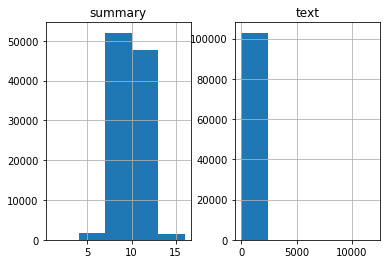

In [43]:
# import matplotlib.pyplot as plt

# graph_df.hist(bins = 5)
# plt.show()

In [44]:
# #Check how much % of summary have 0-15 words
# cnt=0
# for i in pre['cleaned_summary']:
#     if(len(i.split())<=15):
#         cnt=cnt+1
# print(cnt/len(pre['cleaned_summary']))

0.9999805664869067


In [45]:
# #Check how much % of text have 0-70 words
# cnt=0
# for i in pre['cleaned_text']:
#     if(len(i.split())<=100):
#         cnt=cnt+1
# print(cnt/len(pre['cleaned_text']))

0.9578389933440218


In [15]:
df['cleaned_text'] = pd.Series(preprocessor.clean_text(df['text']))
df['cleaned_summary'] = pd.Series(preprocessor.clean_text(df['summary']))

In [16]:
pre = df

In [22]:
len(pre['cleaned_text']), len(pre['cleaned_summary'])

(102915, 102915)

In [26]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=100
max_summary_len=15

In [27]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [28]:
post_pre.shape

(98572, 2)

In [31]:
post_pre = pd.read_csv('./news_summary.csv')
post_pre.shape

(98574, 2)

In [32]:
post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...


In [33]:
post_pre.shape
# (98574, 2)

(98574, 2)

In [34]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')


In [35]:
post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok upgrad learner switches to career in ml...
1,kunal shah credit card bill payment platform c...,sostok delhi techie wins free food from swiggy...


**SEQ2SEQ MODEL BUILDING **

Split the data to TRAIN and VALIDATION sets

In [38]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=42,shuffle=True)

In [42]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

AttributeError: 'float' object has no attribute 'lower'

**RARE WORD ANALYSIS FOR X i.e 'text'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [53]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 57.9523665354728
Total Coverage of rare words: 1.3407638901855343


In [54]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 33333


**RARE WORD ANALYSIS FOR Y i.e 'summary'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [55]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [56]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.22310223335177
Total Coverage of rare words: 4.15134272933284


In [57]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 11601


We will now remove "Summary" i.e Y (both train and val) which has only _START_ and _END_

In [58]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [59]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [60]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Size of vocabulary from the w2v model = 33333
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     6666600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
________________________________________________

In [61]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [62]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


**Start fitting the model with the data**

In [63]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=8,callbacks=[es],batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 88716 samples, validate on 9858 samples
Epoch 1/8
88716/88716 [==============================] - 184s 2ms/sample - loss: 5.1898 - val_loss: 4.8612
Epoch 2/8
88716/88716 [==============================] - 177s 2ms/sample - loss: 4.7895 - val_loss: 4.5981
Epoch 3/8
88716/88716 [==============================] - 176s 2ms/sample - loss: 4.5212 - val_loss: 4.3548
Epoch 4/8
88716/88716 [==============================] - 177s 2ms/sample - loss: 4.2925 - val_loss: 4.1756
Epoch 5/8
88716/88716 [==============================] - 176s 2ms/sample - loss: 4.1199 - val_loss: 4.0465
Epoch 6/8
88716/88716 [==============================] - 176s 2ms/sample - loss: 3.9789 - val_loss: 3.9340
Epoch 7/8
88716/88716 [==============================] - 175s 2ms/sample - loss: 3.8622 - val_loss: 3.8528
Epoch 8/8
88716/88716 [==============================] - 176s 2ms/sample - loss: 3.7672 - val_loss: 3.7860


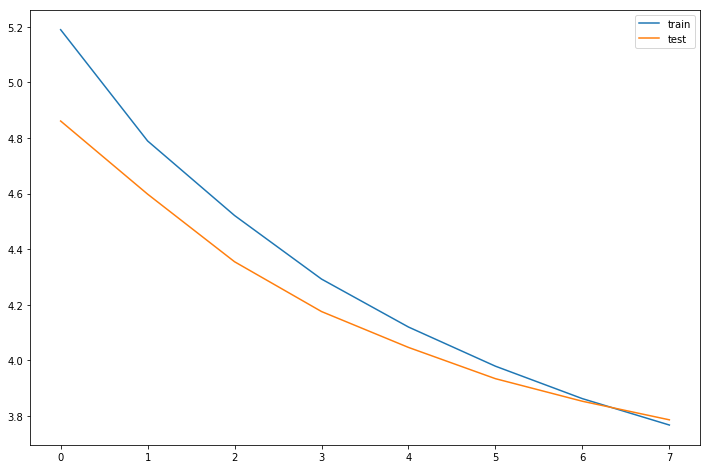

In [76]:
plt.figure(figsize=(12, 8)) 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [80]:
model.save('sequence_2_sequence.keras')
model.save('sequence_2_sequence.h5')

**Visualize the model learning**

In [79]:
print('ok')

ok


**Next, let’s build the dictionary to convert the index to word for target and source vocabulary:**

In [65]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [66]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

**We are defining a function below which is the implementation of the inference process**

In [81]:
import pickle

model_components = {
    'x_tokenizer': x_tokenizer,
    'y_tokenizer': y_tokenizer,
    'reverse_source_word_index': reverse_source_word_index,
    'reverse_target_word_index': reverse_target_word_index,
    'target_word_index': target_word_index,
    'max_text_len': max_text_len,
    'max_summary_len': max_summary_len
}

with open('model_components.pkl', 'wb') as f:
    pickle.dump(model_components, f)
    print('Model components saved successfully...')
    

# encoder_model.save('encoder_model.keras')
# decoder_model.save('decoder_model.keras')
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

Model components saved successfully...


ValueError: Could not pack sequence. Structure had 4 elements, but flat_sequence had 3 elements.  Structure: [<tf.Tensor 'input_2:0' shape=(?, ?) dtype=float32>, <tf.Tensor 'input_5:0' shape=(?, 100, 300) dtype=float32>, <tf.Tensor 'input_3:0' shape=(?, 300) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 300) dtype=float32>], flat_sequence: [<tensorflow.python.keras.utils.tf_utils.ListWrapper object at 0x78ea38080978>, <tensorflow.python.keras.utils.tf_utils.ListWrapper object at 0x78ea38080ef0>, <tensorflow.python.keras.utils.tf_utils.ListWrapper object at 0x78ea38080f60>].

In [83]:
encoder_model

In [67]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

**Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:**


In [68]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

**Run the model over the data to see the results**

In [70]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: in an apparent reference to aimim chief asaduddin owaisi comment about muslim casualties in the sunjuwan attack the northern command chief lieutenant general devraj anbu said we don communalise martyrs those making statements don know the army well the enemy is frustrated and is trying to strike softer targets when they fail at borders they attack on camps he added 
Original summary: we don martyrs army northern command chief 
Predicted summary:  will be in kashmir if it is not to be rss


Review: music composer himesh reshammiya has signed five year old reality show contestant kumar for song he added after hearing him reciting the hanuman chalisa on stage felt he could be the next big singer in the industry previously himesh has signed reality show contestants like palak muchhal and singh to sing for bollywood films 
Original summary: signs 5 yr old reality show contestant for song 
Predicted summary:  i am the best of the best actor


Review: saudi journalist and critic jamal